# Simpeg 2D inversion Using MTpy-v2 tools

This is an example of how to use MTpy-v2 tools to integrate with Simpeg to build an inversion.  

The recipe in MTpy-v2 is to create a quadree mesh from the given data, then invert the data using computed data errors




In [1]:
import numpy as np

from mtpy import MTCollection
from mtpy.modeling.simpeg.recipes import Simpeg2D

## Load in data

We are going to load in data from a synthetic model that has some northeast trending faults in the upper 5 km.  The data were modeled to be in Australia which is why the EPSG is 4462 (the UTM datum for all of Australia).  The data are already in a profile, but we will demonstrate how to extract a profile line from the data by using the end points (usually in lat, lon).  The data are modeled from 3E-4 to 1E+3.

Steps:

 1) Read in EDI files into an MTData object
 2) Project station locations onto a UTM grid (EPSG = 4462)
 3) Extract the profile
 4) Interpolate onto a common period map
 5) Compute data errors for modeling (usually set an error floor)

### 1) load in data to an MTData object

Here we are taking every third station just to keep the inversion small.  You can change the number to get smaller or bigger data sets to invert.

In [9]:

with MTCollection() as mc:
    mc.open_collection(r"../../data/transfer_functions/forward_profiles.h5")
    other_survey_options = '\n\t'.join(mc.mth5_collection.surveys_group.groups_list)
    mc.working_dataframe = mc.master_dataframe[mc.master_dataframe.survey == "conductive_cube"]
    md = mc.to_mt_data()


24:10:15T15:15:32 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing ..\..\data\transfer_functions\forward_profiles.h5


In [11]:
print(f"Other survey options are: \n\t{other_survey_options}")

Other survey options are: 
	conductive_cube
	faults
	layered_halfspace
	ne_conductor
	ne_faults
	near_surface_conductor
	resistive_cube


### 2) Set UTM Grid

In [12]:

md.utm_epsg = 4426

#### 2a) plot stations

24:10:15T15:15:51 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636


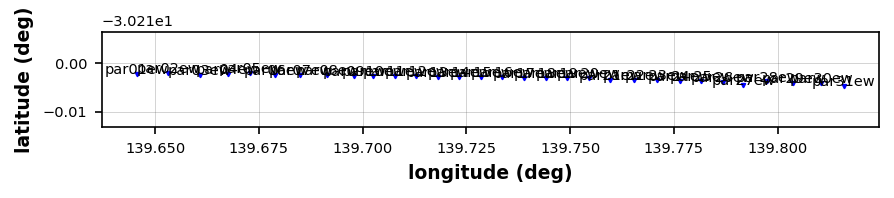

In [13]:

station_plot = md.plot_stations()

### 3) extract profile

This is an example of how to extract a profile from a grid of stations.  You need to know the end points of the profile, usually in (longitude, latitude) and then you can set a distance from that profile line to include station.  

<div class="alert alert-block alert-info">
<b>Note:</b> You should pick your profile line to be approximately perpendicular to geoelectric strike.  To look at geoelectric strike you can use MTData.plot_strike().  See also MTData.generate_profile_from_strike()
</div>

In [14]:

profile = md.get_profile(139.50, -30.211997, 139.9, -30.214724527777776, 5000)

#### 3a) plot profile

Be sure you got all the station you were asking for.  

24:10:15T15:16:11 | WARNING | line:163 |mtpy.imaging.plot_stations | plot | Could not add base map because Tile URL resulted in a 404 error. Double-check your tile url:
https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/12/2408/3636


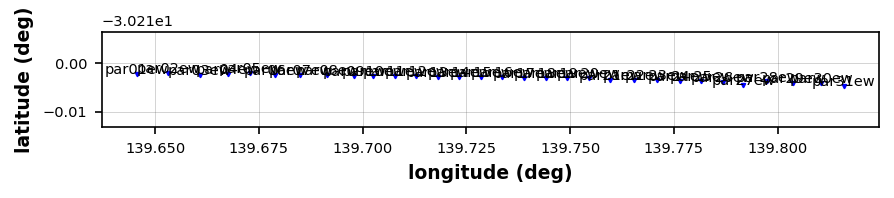

In [15]:

plot_profile = profile.plot_stations()

In [16]:
# 4) Interpolate data onto the same period map
# It is important to use bounds_error=False, which will put Nan where data cannot
# be interpolated. Interpolate onto a period range that keeps the mesh small. 
# decrease the first number to get shorter periods.
profile.interpolate(np.logspace(-1, 3, 5), inplace=True, bounds_error=False)

In [17]:
# 5) set data modeling errors, set an error floor of 5 % for the impedance
profile.z_model_error.error_value = 5
profile.z_model_error.error_type = "percent"
profile.z_model_error

Model Errors:
--------------------
	error_type:    percent
	error_value:   0.05
	floor:         True
	mode:          impedance

In [18]:
profile.compute_model_errors()

## Run 2D inversion

Now use a somewhat standard recipe to invert the data.  User has lots of control of parameters for mesh building, inversion norms, smallness, etc.  This recipe is meant as a convenience object.  For advanced users and those who want to fully understand the Simpeg workflow should build their own recipe.

Here the input data is a Pandas Dataframe.  There is a method in MTData to create a Simpeg Data object.

C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy-v2\mtpy\modeling\simpeg\make_2d_mesh.py:262: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


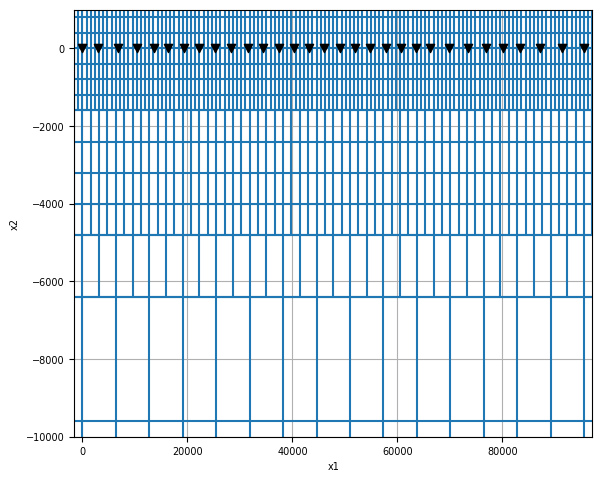

In [19]:
simpeg_2d = Simpeg2D(
    profile.to_dataframe(),
    mesh_kwargs={},
    data_kwargs={},
    max_iterations=10, 
    )

In [11]:
print(simpeg_2d)

Attributes:
	air_conductivity: 1e-08
	alpha_s: 1e-05
	alpha_y: 0.2
	alpha_z: 1.0
	beta_cooling_factor: 2
	beta_cooling_rate: 1
	beta_starting_ratio: 1
	f_min_change: 1e-05
	initial_conductivity: 0.01
	max_iterations: 10
	max_iterations_cg: 30
	max_iterations_irls: 40
	minimum_gauss_newton_iterations: 1
	p_s: 0
	p_y: 0
	p_z: 0
	solver: pardiso
	target_misfit_chi_factor: 1
	use_irls: False
Properties:
	active_map: InjectActiveCells(2056,1028)
	beta_schedule: <simpeg.directives.directives.BetaSchedule object at 0x000002497A14AC40>
	conductivity_map: ComboMap[ExpMap(2056,2056) * InjectActiveCells(2056,1028)](2056,1028)
	data_misfit: <simpeg.objective_function.ComboObjectiveFunction object at 0x000002497BD65700>
	directives: [<simpeg.directives.directives.BetaEstimate_ByEig object at 0x000002497BD656A0>, <simpeg.directives.directives.BetaSchedule object at 0x000002497BD65610>, <simpeg.directives.directives.SaveOutputDictEveryIteration object at 0x000002497A002970>, <simpeg.directives.direct

In [20]:
%%time
inversion_output = simpeg_2d.run_inversion()


Running inversion with SimPEG v0.22.1

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.41e-02  1.34e+05  0.00e+00  1.34e+05    1.76e+05      0              
   1  2.21e-02  2.67e+04  3.30e+04  2.74e+04    2.46e+04      0              
   2  1.10e-02  1.15e+04  1.17e+05  1.28e+04    3.88e+03      0   Skip BFGS  
   3  5.52e-03  5.99e+03  2.66e+05  7.46e+03    8.74e+02      0   Skip BFGS  
   4  2.76e-03  4.34e+03  4.00e+05  5.44e+03    4.27e+02      0   Skip BFGS  
   5  1.38e-03  3.68e+03  5.40e+05  4.43e+03    2.80e+02      0   

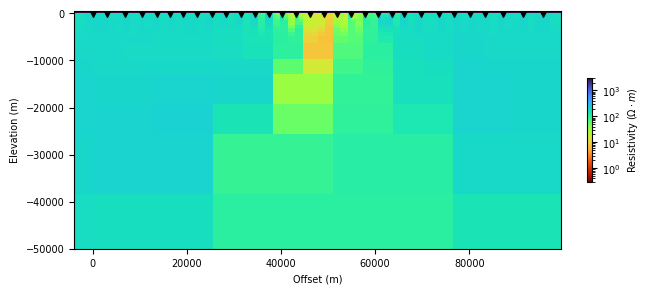

In [21]:
simpeg_2d.plot_iteration(10, z_limits=(-50000, 500))

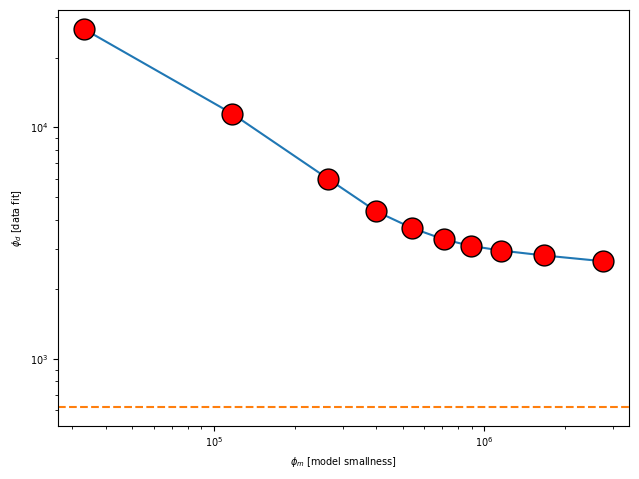

In [22]:
simpeg_2d.plot_tikhonov_curve()